<a href="https://colab.research.google.com/github/vivianaalba/ml-trash-sorter/blob/main/notebook/trash-classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# DSCI 552 Final Project

Name: Viviana Alba <br>
Github Username: vivianaalba <br>
USC ID: 7670708537

In [1]:
# imports
import numpy as np
import pandas as pd
import os
import shutil
import zipfile

import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image

from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications import ResNet101
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.applications import VGG16

from tensorflow.keras.applications.resnet import preprocess_input as resnet_preprocess
from tensorflow.keras.applications.efficientnet import preprocess_input as efficientnet_preprocess
from tensorflow.keras.applications.vgg16 import preprocess_input as vgg_preprocess

import tensorflow as tf
from tensorflow.keras.utils import to_categorical, image_dataset_from_directory
from tensorflow.keras import layers, models, regularizers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.metrics import AUC

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.utils.class_weight import compute_class_weight


Mounted at /content/drive


In [9]:
# clone repo
!git clone https://github.com/vivianaalba/ml-trash-sorter.git

# confirm access to data
data_path = "/content/ml-trash-sorter/data/RealWaste"

folders = [f for f in os.listdir(data_path) if os.path.isdir(os.path.join(data_path, f))]

print(f"Found {len(folders)} folders:")
print(folders)

Found 9 folders:
['1-Cardboard', '4-Metal', '2-Food Organics', '7-Plastic', '9-Vegetation', '8-Textile Trash', '5-Miscellaneous Trash', '6-Paper', '3-Glass']


## 1. Transfer Learning for Image Classification
It is highly recommended that you complete this project using Keras (https://keras.io) and Python.

### (a) Build a classifier that distinguishes images of nine types of waste

### (b) Data Exploration and Pre-Processing
i. Images are numbered in each folder. Select the first 80% of the images in each folder as your training set and the rest as the test set. You can encode your classes using one-hot encoding. <br>

ii. In case all the images do not have the same size, zero-pad or resize the images in your dataset. This can be done using various tools, including OpenCV.

In [10]:

folders = [
    "1-Cardboard", "2-Food Organics", "3-Glass",
    "4-Metal", "5-Miscellaneous Trash", "6-Paper",
    "7-Plastic", "8-Textile Trash", "9-Vegetation"
]

train_images = []
test_images = []

# count photos in each folder to split into train / test data
def count_files_in_directory(folders):
    folder_data = {}
    for folder_name in folders:
        folder_path = os.path.join(data_path, folder_name)
        image_files = sorted([
            f for f in os.listdir(folder_path) if f.endswith(".jpg")
        ])
        folder_data[folder_name] = len(image_files)
    return folder_data

file_count_dict = count_files_in_directory(folders)

# access and store data in lists
for folder, n_images in file_count_dict.items():
    class_name = folder.split("-", 1)[1]
    n_images_train = int(round(n_images * 0.8))
    n_images_test = n_images - n_images_train

    for i in range(1, n_images_train + 1):
        image_path = f"{data_path}/{folder}/{class_name}_{i}.jpg"
        if os.path.exists(image_path):
            width, height = Image.open(image_path).size
            train_images.append([image_path, class_name, folder, width, height])

    for i in range(n_images_train + 1, n_images + 1):
        image_path = f"{data_path}/{folder}/{class_name}_{i}.jpg"
        if os.path.exists(image_path):
            width, height = Image.open(image_path).size
            test_images.append([image_path, class_name, folder, width, height])

# make train and test dfs - used later to make new directories for the images
image_cols = ["Image Path", "Class", "Folder", "Width", "Height"]
train_data_df = pd.DataFrame(train_images, columns=image_cols)
test_data_df = pd.DataFrame(test_images, columns=image_cols)

print(train_data_df.head())
print(test_data_df.head())

                                          Image Path      Class       Folder  \
0  /content/ml-trash-sorter/data/RealWaste/1-Card...  Cardboard  1-Cardboard   
1  /content/ml-trash-sorter/data/RealWaste/1-Card...  Cardboard  1-Cardboard   
2  /content/ml-trash-sorter/data/RealWaste/1-Card...  Cardboard  1-Cardboard   
3  /content/ml-trash-sorter/data/RealWaste/1-Card...  Cardboard  1-Cardboard   
4  /content/ml-trash-sorter/data/RealWaste/1-Card...  Cardboard  1-Cardboard   

   Width  Height  
0    524     524  
1    524     524  
2    524     524  
3    524     524  
4    524     524  
                                          Image Path      Class       Folder  \
0  /content/ml-trash-sorter/data/RealWaste/1-Card...  Cardboard  1-Cardboard   
1  /content/ml-trash-sorter/data/RealWaste/1-Card...  Cardboard  1-Cardboard   
2  /content/ml-trash-sorter/data/RealWaste/1-Card...  Cardboard  1-Cardboard   
3  /content/ml-trash-sorter/data/RealWaste/1-Card...  Cardboard  1-Cardboard   
4  /c

In [11]:
# check for differences in image size by looking at variance
# std of 0 means all width, height of images are the same for that dataset (train / test)
print(f"Train Width STD: {train_data_df['Width'].std()}, Train Height STD: {train_data_df['Height'].std()}")
print(f"Test Width STD: {test_data_df['Width'].std()}, Test Height STD: {test_data_df['Height'].std()}")

# given variance below, all images are of the same size, no image resizing will be needed for this data set

Train Width STD: 0.0, Train Height STD: 0.0
Test Width STD: 0.0, Test Height STD: 0.0


### (c) Transfer Learning
https://builtin.com/data-science/transfer-learning <br>

i. When dealing with classification of relatively small image datasets, deep networks may not perform very well because of not having enough data to train them. In such cases, one usually uses transfer learning, which uses deep learning models that are trained on very large datasets such as ImageNet as feature extractors. The idea is that such deep networks have learned to extract meaningful features from an image using their layers, and those features can be used in learning other tasks. In order to do that, usually the last layer or the last few layers of the pre-trained network are removed, and the response of the layer before the removed layers to the images in the new dataset is used as a feature vector to train one more multiple replacement layers. In this project, you will use pre-trained models ResNet50, ResNet100, EfficientNetB0, and VGG16. For those pre-trained networks, you will only train the last fully connected layer, and will freeze all layers before them (i.e. we do not change their parameters during training) and use the outputs of the penultimate layer in the original pre-trained model as the features extracted from each image. <br>

ii. To perform empirical regularization, crop, randomly zoom, rotate, flip, contrast, and translate images in your training set for image augmentation. You can use various tools to do this, including OpenCV. <br>

iii. Use ReLU activation functions in the last layer and a softmax layer, along with L2 regularization, batch normalization (https://en.wikipedia.org/wiki/Batch_normalization), and a dropout rate of 20% as well as ADAM optimizer. Use multinomial cross entropy loss. You can try any batch size, but a batch size of 5 seems reasonable. <br>

iv. Train the networks for at least 50 epochs (preferably 100 epochs) and perform early stopping using the validation set. Use a randomly selected subset of 20% of each class as the validation set. Keep the network parameters that have the lowest validation error. Plot the training and validation errors vs. epochs. <br>

v. Report training, validation, and test Precision, Recall, AUC, and F1 score for those models. Is there a model that clearly outperforms others? Remember that this is a multi-class classification problem. <br>


In [ ]:
# create directory for train and test images organized by class
def get_image_directory(df, split_name, base_output_dir):
    output_dir = os.path.join(base_output_dir, split_name)
    os.makedirs(output_dir, exist_ok=True)

    for _, row in df.iterrows():
        img_path = row["Image Path"]
        class_name = row["Class"]

        # create subdirectory for class if it doesn't exist
        class_dir = os.path.join(output_dir, class_name)
        os.makedirs(class_dir, exist_ok=True)

        # copy image to new location
        dest_path = os.path.join(class_dir, os.path.basename(img_path))
        if not os.path.exists(dest_path):  # avoids duplicate copying
            shutil.copy(img_path, dest_path)

    print(f"Finished organizing {split_name} data at: {output_dir}")

# used with Google Colab
get_image_directory(train_data_df, split_name="train", base_output_dir="/content/organized_data")
get_image_directory(test_data_df, split_name="test", base_output_dir="/content/organized_data")

Finished organizing train data at: /content/organized_data/train
Finished organizing test data at: /content/organized_data/test


In [ ]:
# perform empirical regularization - used unique data augmentation for each model
# crop, randomly zoom, rotate, flip, contrast, and translate images in training set
# only augment train data

def get_augmented_data(data_augmentation, train_ds, test_ds, val_ds, model_name):
    train_data_augmented = train_ds.map(
        lambda x, y: (data_augmentation(x, training=True), y),
        num_parallel_calls=tf.data.AUTOTUNE
    ).prefetch(tf.data.AUTOTUNE)

    # select preprocessing function based on model
    # originally, i used rescale_only = tf.keras.Sequential([layers.Rescaling(1./255)]) but my models were under-performing and training slowly
    if model_name in ["ResNet101", "ResNet50"]:
        preprocess_only = tf.keras.Sequential([layers.Lambda(resnet_preprocess)])
    elif model_name == "EfficientNetB0":
        preprocess_only = tf.keras.Sequential([layers.Lambda(efficientnet_preprocess)])
    elif model_name == "VGG16":
        preprocess_only = tf.keras.Sequential([layers.Lambda(vgg_preprocess)])
    else:
        raise ValueError(f"Unknown model name: {model_name}")

    # preprocessing only for validation and test sets
    test_ds = test_ds.map(
        lambda x, y: (preprocess_only(x), y),
        num_parallel_calls=tf.data.AUTOTUNE
    ).prefetch(tf.data.AUTOTUNE)

    val_ds = val_ds.map(
        lambda x, y: (preprocess_only(x), y),
        num_parallel_calls=tf.data.AUTOTUNE
    ).prefetch(tf.data.AUTOTUNE)

    return train_data_augmented, val_ds, test_ds

In [ ]:
# use pre-trained models ResNet50, ResNet100, EfficientNetB0, and VGG16
# only train the last fully connected layer
# freeze all layers before them (i.e. we do not change their parameters during training)
# use the outputs of the penultimate layer in the original pre-trained model as the features extracted from each image

# load ResNet50
resnet50_base = ResNet50(
    weights = "imagenet", # pre-training on ImageNet
    include_top = False, # train the last fully connected layer
    input_shape = (224, 224, 3) # match with image_size in tf.data.Dataset
)

resnet50_base.trainable = False # freeze layers

# load ResNet101
resnet101_base = ResNet101(
    weights = "imagenet",
    include_top = False,
    input_shape = (224, 224, 3)
)

resnet101_base.trainable = False

# load EfficientNetB0
efficientnetb0_base = EfficientNetB0(
    weights = "imagenet",
    include_top = False,
    input_shape = (224, 224, 3)
)

efficientnetb0_base.trainable = False

# load VGG16
vgg16_base = VGG16(
    weights = "imagenet",
    include_top = False,
    input_shape = (224, 224, 3)
)

vgg16_base.trainable = False

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
171446536/171446536 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
# for training, validation, and test data - report Precision, Recall, AUC, and F1 score
def get_metrics(dataset, model):
    y_true = []
    y_pred_probs = []

    for images, labels in dataset:
        y_true.extend(np.argmax(labels.numpy(), axis=1))
        y_pred_probs.extend(model.predict(images, verbose=0))

    y_pred_probs = np.array(y_pred_probs)
    y_pred = np.argmax(y_pred_probs, axis=1)
    y_true = np.array(y_true)

    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='macro', zero_division=0)
    recall = recall_score(y_true, y_pred, average='macro')
    f1 = f1_score(y_true, y_pred, average='macro')

    try:
        # use One-vs-Rest bc we have multiclass data
        auc = roc_auc_score(
            y_true,
            y_pred_probs,
            multi_class='ovr',
            average='macro'
        )
    except ValueError as e:
        auc = "N/A"

    return accuracy, precision, recall, f1, auc

In [ ]:
# check for class imbalance
train_data_df['Class'].value_counts()

# some imbalance between classes - plastic has 737 entries, while textile trash has 254 entries
# can add class balancing methods to models to see if balancing can help models

,count
Class,
Plastic,737
Metal,632
Paper,400
Miscellaneous Trash,396
Cardboard,369
Vegetation,349
Glass,336
Food Organics,329
Textile Trash,254


In [ ]:
# Use ReLU activation functions in the last layer and a softmax layer,
# L2 regularization, batch normalization (https://en.wikipedia.org/wiki/Batch_normalization), and a dropout rate of 20% as well as ADAM optimizer.
# Use multinomial cross entropy loss.

def train_assess_model(model_name, final_model, data_augmentation, n_epochs, learn_rate, batch=5, smoothing_rate=0, class_balance=False):

    # get databases - returns tf.data.Dataset from our train and test directories
    # folder paths set to work with Google Colab
    train_data = image_dataset_from_directory(
        "/content/organized_data/train",
        validation_split=0.2,
        subset="training",
        seed=13,
        label_mode='categorical',
        batch_size=batch,
        image_size=(224, 224),
        shuffle=True
    )

    class_names = train_data.class_names

    val_data = image_dataset_from_directory(
        "/content/organized_data/train",
        validation_split=0.2,
        subset="validation",
        seed=13,
        label_mode='categorical',
        batch_size=batch,
        image_size=(224, 224),
        shuffle=True
    )

    test_data = image_dataset_from_directory(
        "/content/organized_data/test",
        label_mode='categorical',
        batch_size=batch,
        image_size=(224, 224),
        shuffle=False
    )

    # augment and preprocess train_data, test_data, val_data according to model
    train_aug, val_aug, test_aug = get_augmented_data(
        data_augmentation,
        train_data, test_data, val_data,
        model_name
    )

    if smoothing_rate:  # add optional class smoothing, which may help some models generalize better
        loss = tf.keras.losses.CategoricalCrossentropy(label_smoothing=smoothing_rate) # lower label_smoothing, less regularization
    else:
        loss='categorical_crossentropy'

    final_model.compile(
        optimizer=Adam(learning_rate=learn_rate), #lower LR may help with transfer learning
        loss=loss,
        metrics=[AUC(name='auc')]
    )

    # Train the networks for at least 50 epochs (preferably 100 epochs) and perform early stopping using the validation set
    # Keep the network parameters that have the lowest validation error
    model_download_name = f"best_mode_{model_name}.keras"

    # reduce LR on plataue in attempt of reaching a lower minimum
    callbacks = [
        ReduceLROnPlateau(monitor='val_auc', factor=0.5, patience=10, min_lr=1e-7, verbose=1, mode='max'), # reduce LR after epochs
        EarlyStopping(monitor='val_auc', patience=50, min_delta=0.001, restore_best_weights=True, mode='max'), # make sure to train AT LEAST 50 epochs
        ModelCheckpoint(model_download_name, monitor='val_auc', save_best_only=True, mode='max')
    ]

    # some imbalance between classes like Plastic (737 datapoints) and Textile Trash (254 data points)
    # can lead to overfitting model
    if class_balance:
        class_indices = {name: i for i, name in enumerate(class_names)}
        labels = [class_indices[row["Class"]] for _, row in train_data_df.iterrows()]
        class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(labels),y=labels)
        class_weight_dict = dict(enumerate(class_weights)) # get class weights and balance

        history = final_model.fit(
            train_aug,
            validation_data=val_aug,
            epochs=n_epochs,
            callbacks=callbacks,
            class_weight=class_weight_dict # addresses slight class imbalance to improve model
        )
    else:
        history = final_model.fit(
            train_aug,
            validation_data=val_aug,
            epochs=n_epochs,
            callbacks=callbacks,
        )

    # Plot the training and validation errors vs. epochs
    # if early stop is triggered, it will only show the epochs that were completed
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss') # how wrong our predictions are, the lower the loss the better the model
    plt.title('Training vs Validation Loss')
    plt.legend()
    plt.show()

    # get metrics for train, test, and validation datasets
    accuracy_train, precision_train, recall_train, f1_train, auc_train = get_metrics(train_aug, final_model)
    accuracy_val, precision_val, recall_val, f1_val, auc_val = get_metrics(val_aug, final_model)
    accuracy_test, precision_test, recall_test, f1_test, auc_test = get_metrics(test_aug, final_model)

    metric_cols = [
        "model",
        "accuracy_train", "precision_train", "recall_train", "f1_train", "auc_train",
        "accuracy_val", "precision_val", "recall_val", "f1_val", "auc_val",
        "accuracy_test", "precision_test", "recall_test", "f1_test", "auc_test"
    ]

    metric_data = [[
        model_name,
        accuracy_train, precision_train, recall_train, f1_train, auc_train,
        accuracy_val, precision_val, recall_val, f1_val, auc_val,
        accuracy_test, precision_test, recall_test, f1_test, auc_test
    ]]

    assessment_df = pd.DataFrame(metric_data, columns=metric_cols)
    return assessment_df # return metrics as a df, which can be combined in df with metrics of all models

Found 3802 files belonging to 9 classes.
Using 3042 files for training.
Found 3802 files belonging to 9 classes.
Using 760 files for validation.
Found 950 files belonging to 9 classes.
Epoch 1/100
609/609 ━━━━━━━━━━━━━━━━━━━━ 43s 49ms/step - auc: 0.5014 - loss: 3.2872 - val_auc: 0.5467 - val_loss: 3.6587 - learning_rate: 1.0000e-06
Epoch 2/100
609/609 ━━━━━━━━━━━━━━━━━━━━ 21s 34ms/step - auc: 0.5161 - loss: 3.2406 - val_auc: 0.5569 - val_loss: 3.7124 - learning_rate: 1.0000e-06
Epoch 3/100
609/609 ━━━━━━━━━━━━━━━━━━━━ 21s 34ms/step - auc: 0.5223 - loss: 3.1727 - val_auc: 0.5712 - val_loss: 3.6335 - learning_rate: 1.0000e-06
Epoch 4/100
609/609 ━━━━━━━━━━━━━━━━━━━━ 21s 34ms/step - auc: 0.5578 - loss: 2.9610 - val_auc: 0.5839 - val_loss: 3.5585 - learning_rate: 1.0000e-06
Epoch 5/100
609/609 ━━━━━━━━━━━━━━━━━━━━ 21s 34ms/step - auc: 0.5665 - loss: 2.9132 - val_auc: 0.6078 - val_loss: 3.3568 - learning_rate: 1.0000e-06
Epoch 6/100
609/609 ━━━━━━━━━━━━━━━━━━━━ 21s 35ms/step - auc: 0.5801 -

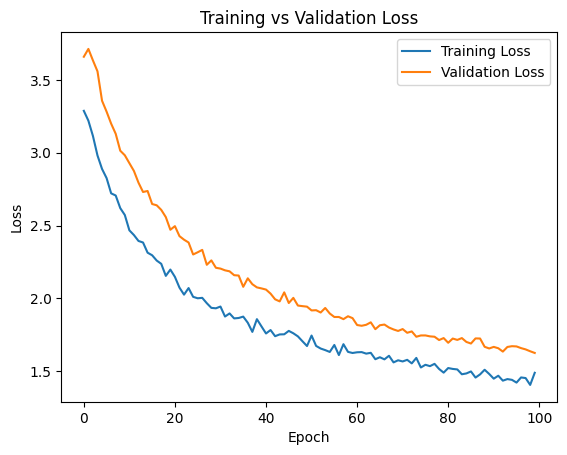

      model  accuracy_train  precision_train  recall_train  f1_train  \
0  ResNet50        0.671269         0.666595      0.700302  0.673932   

   auc_train  accuracy_val  precision_val  recall_val  f1_val   auc_val  \
0   0.943781      0.552632       0.541804    0.545184  0.5368  0.892764   

   accuracy_test  precision_test  recall_test   f1_test  auc_test  
0           0.58        0.558108     0.563008  0.556939  0.895267  


In [ ]:
resnet50_data_aug = tf.keras.Sequential([
    layers.CenterCrop(height=200, width=200),
    layers.Resizing(224, 224),
    layers.RandomFlip("horizontal_and_vertical"), # trash can appear in any direction, so use both
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
    layers.RandomTranslation(0.05, 0.05),
    layers.RandomContrast(0.2),
    layers.RandomSaturation(0.1),
    layers.Lambda(resnet_preprocess)
])

resnet50_params = models.Sequential([
    layers.Input(shape=(224, 224, 3)), # input layer
    resnet50_base, # remaining frozen layers,
    layers.GlobalAveragePooling2D(), # flatten feature maps

    # started w/ one relu 128 activation layer, but model was performing poorly, so increased neurons + layers
    # dense num creates a layer with X nuerons - larger layer learns more patterns, but needs more data to generalize well
    layers.Dense(512, activation='relu', kernel_regularizer=regularizers.l2(0.0001)),
    layers.BatchNormalization(),
    layers.Dropout(0.2),

    layers.Dense(512, activation='relu'), # only regularize one layer to prevent overegularization / underfitting
    layers.BatchNormalization(),
    layers.Dropout(0.2), # as stated in assignment

    # final classifier w/ softmax, give class probabilities
    # use 9 neurons bc we have 9 output classes
    layers.Dense(9, activation='softmax')
])

resnet50_assess_df = train_assess_model(
    "ResNet50", resnet50_params, resnet50_data_aug,
    n_epochs=100,
    learn_rate=1e-6,
    batch=5,
    smoothing_rate=0.01,
    class_balance=True
)
print(resnet50_assess_df)

Found 3802 files belonging to 9 classes.
Using 3042 files for training.
Found 3802 files belonging to 9 classes.
Using 760 files for validation.
Found 950 files belonging to 9 classes.
Epoch 1/100
381/381 ━━━━━━━━━━━━━━━━━━━━ 63s 107ms/step - auc: 0.6920 - loss: 3.4362 - val_auc: 0.8812 - val_loss: 2.8907 - learning_rate: 1.0000e-04
Epoch 2/100
381/381 ━━━━━━━━━━━━━━━━━━━━ 27s 69ms/step - auc: 0.8622 - loss: 2.7669 - val_auc: 0.9039 - val_loss: 2.7891 - learning_rate: 1.0000e-04
Epoch 3/100
381/381 ━━━━━━━━━━━━━━━━━━━━ 27s 69ms/step - auc: 0.8968 - loss: 2.5962 - val_auc: 0.9101 - val_loss: 2.7164 - learning_rate: 1.0000e-04
Epoch 4/100
381/381 ━━━━━━━━━━━━━━━━━━━━ 27s 69ms/step - auc: 0.9137 - loss: 2.4821 - val_auc: 0.9259 - val_loss: 2.5910 - learning_rate: 1.0000e-04
Epoch 5/100
381/381 ━━━━━━━━━━━━━━━━━━━━ 27s 69ms/step - auc: 0.9216 - loss: 2.4226 - val_auc: 0.9366 - val_loss: 2.4941 - learning_rate: 1.0000e-04
Epoch 6/100
381/381 ━━━━━━━━━━━━━━━━━━━━ 27s 69ms/step - auc: 0.9350 

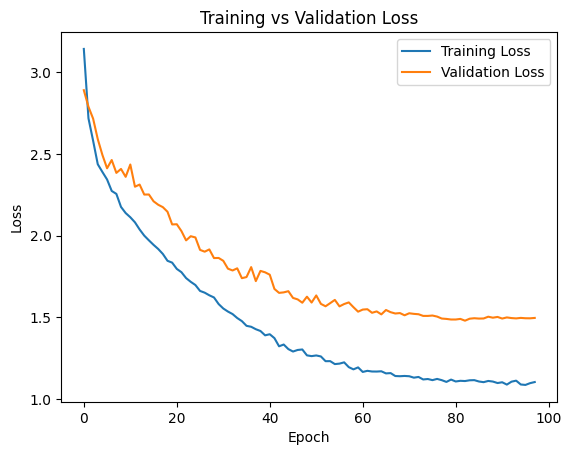

       model  accuracy_train  precision_train  recall_train  f1_train  \
0  ResNet101        0.950362         0.950173      0.959713  0.954564   

   auc_train  accuracy_val  precision_val  recall_val    f1_val   auc_val  \
0   0.998606      0.753947       0.762996    0.739856  0.740293  0.965155   

   accuracy_test  precision_test  recall_test   f1_test  auc_test  
0       0.687368        0.699234     0.669716  0.664182  0.948954  


In [ ]:
resnet101_data_aug = tf.keras.Sequential([
    layers.CenterCrop(height=200, width=200),
    layers.Resizing(224, 224),
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.2),
    layers.RandomTranslation(0.1, 0.1),
    layers.RandomContrast(0.1),
    layers.RandomSaturation(0.1),
    layers.Lambda(resnet_preprocess)
])

resnet101_params = models.Sequential([
    layers.Input(shape=(224, 224, 3)), # input layer
    resnet101_base, # remaining frozen layers,
    layers.GlobalAveragePooling2D(), # flatten feature maps

    layers.Dense(564, activation='relu', kernel_initializer='he_normal', kernel_regularizer=regularizers.l2(0.001)),
    layers.BatchNormalization(),
    layers.Dropout(0.2),

    layers.Dense(128, activation='relu', kernel_initializer='he_normal', kernel_regularizer=regularizers.l2(0.0001)),
    layers.BatchNormalization(),
    layers.Dropout(0.2),

    # final classifier w/ softmax, give class probabilities
    # use 9 neurons bc we have 9 output classes
    layers.Dense(9, activation='softmax')
])

resnet101_assess_df = train_assess_model(
    "ResNet101", resnet101_params, resnet101_data_aug,
    n_epochs=100,
    learn_rate=1e-4,
    batch=8,
    smoothing_rate=0.1,
    class_balance=True
)
print(resnet101_assess_df)


Found 3802 files belonging to 9 classes.
Using 3042 files for training.
Found 3802 files belonging to 9 classes.
Using 760 files for validation.
Found 950 files belonging to 9 classes.
Epoch 1/100
381/381 ━━━━━━━━━━━━━━━━━━━━ 53s 80ms/step - auc: 0.5679 - loss: 2.8162 - val_auc: 0.6987 - val_loss: 2.3176 - learning_rate: 1.0000e-05
Epoch 2/100
381/381 ━━━━━━━━━━━━━━━━━━━━ 16s 40ms/step - auc: 0.7151 - loss: 2.2562 - val_auc: 0.7835 - val_loss: 2.1821 - learning_rate: 1.0000e-05
Epoch 3/100
381/381 ━━━━━━━━━━━━━━━━━━━━ 16s 40ms/step - auc: 0.8012 - loss: 1.9162 - val_auc: 0.8354 - val_loss: 1.9626 - learning_rate: 1.0000e-05
Epoch 4/100
381/381 ━━━━━━━━━━━━━━━━━━━━ 16s 40ms/step - auc: 0.8396 - loss: 1.7610 - val_auc: 0.8681 - val_loss: 1.7996 - learning_rate: 1.0000e-05
Epoch 5/100
381/381 ━━━━━━━━━━━━━━━━━━━━ 16s 40ms/step - auc: 0.8561 - loss: 1.6923 - val_auc: 0.8863 - val_loss: 1.7053 - learning_rate: 1.0000e-05
Epoch 6/100
381/381 ━━━━━━━━━━━━━━━━━━━━ 16s 40ms/step - auc: 0.8824 -

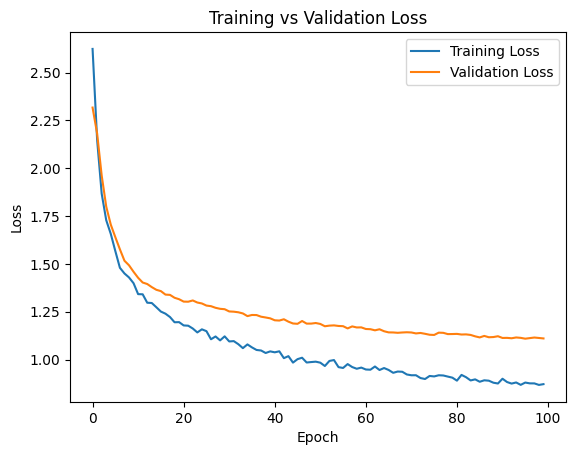

            model  accuracy_train  precision_train  recall_train  f1_train  \
0  EfficientNetB0        0.943458         0.942806      0.953403  0.947591   

   auc_train  accuracy_val  precision_val  recall_val    f1_val   auc_val  \
0   0.998269      0.814474       0.810428    0.819432  0.807108  0.979132   

   accuracy_test  precision_test  recall_test   f1_test  auc_test  
0       0.751579        0.741238     0.756339  0.736158  0.963788  


In [ ]:
efficientnetb0_data_aug = tf.keras.Sequential([
    layers.CenterCrop(height=200, width=200),
    layers.Resizing(224, 224),
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.25),
    layers.RandomZoom(0.2),
    layers.RandomTranslation(0.1, 0.1),
    layers.RandomContrast(0.2),
    layers.Lambda(efficientnet_preprocess)
])

efficientnetb0_params = models.Sequential([
    layers.Input(shape=(224, 224, 3)), # input layer
    efficientnetb0_base, # remaining frozen layers
    layers.GlobalAveragePooling2D(), # flatten feature maps

    # dense num creates a layer with X nuerons - larger layer learns more patterns, but needs more data to generalize well
    layers.Dense(512, activation='relu', kernel_regularizer=regularizers.l2(0.0001)),
    layers.BatchNormalization(),
    layers.Dropout(0.2), # as stated in asignment

    # final classifier w/ softmax, give class probabilities
    # use 9 neurons bc we have 9 output classes
    layers.Dense(9, activation='softmax')
])

efficientnetB0_assess_df = train_assess_model(
    "EfficientNetB0", efficientnetb0_params, efficientnetb0_data_aug,
    n_epochs=100,
    learn_rate=1e-5,
    batch=8,
    smoothing_rate=0.1,
    class_balance=True
)
print(efficientnetB0_assess_df)

Found 3802 files belonging to 9 classes.
Using 3042 files for training.
Found 3802 files belonging to 9 classes.
Using 760 files for validation.
Found 950 files belonging to 9 classes.
Epoch 1/100
609/609 ━━━━━━━━━━━━━━━━━━━━ 36s 52ms/step - auc: 0.5652 - loss: 2.6870 - val_auc: 0.7850 - val_loss: 2.2362 - learning_rate: 1.0000e-04
Epoch 2/100
609/609 ━━━━━━━━━━━━━━━━━━━━ 28s 46ms/step - auc: 0.7605 - loss: 1.9079 - val_auc: 0.8452 - val_loss: 1.9078 - learning_rate: 1.0000e-04
Epoch 3/100
609/609 ━━━━━━━━━━━━━━━━━━━━ 28s 45ms/step - auc: 0.8121 - loss: 1.7255 - val_auc: 0.8621 - val_loss: 1.8339 - learning_rate: 1.0000e-04
Epoch 4/100
609/609 ━━━━━━━━━━━━━━━━━━━━ 28s 46ms/step - auc: 0.8419 - loss: 1.5985 - val_auc: 0.8803 - val_loss: 1.8149 - learning_rate: 1.0000e-04
Epoch 5/100
609/609 ━━━━━━━━━━━━━━━━━━━━ 28s 46ms/step - auc: 0.8578 - loss: 1.5244 - val_auc: 0.8932 - val_loss: 1.6390 - learning_rate: 1.0000e-04
Epoch 6/100
609/609 ━━━━━━━━━━━━━━━━━━━━ 28s 46ms/step - auc: 0.8685 -

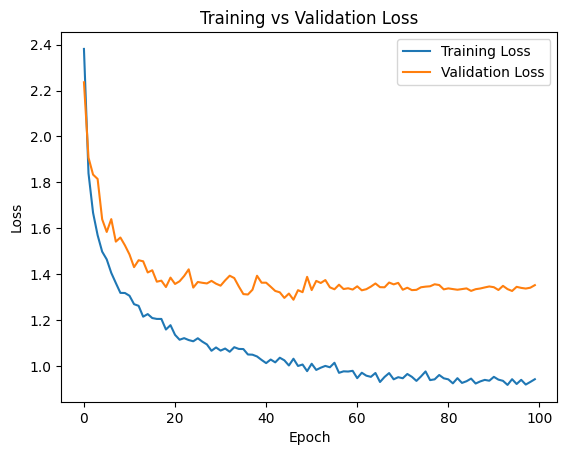

   model  accuracy_train  precision_train  recall_train  f1_train  auc_train  \
0  VGG16        0.831032         0.829621      0.852226  0.838486   0.984378   

   accuracy_val  precision_val  recall_val  f1_val   auc_val  accuracy_test  \
0      0.718421       0.705191    0.717948  0.7043  0.948927       0.663158   

   precision_test  recall_test   f1_test  auc_test  
0        0.652578      0.66519  0.652872  0.933046  


In [ ]:
vgg16_data_aug = tf.keras.Sequential([
    layers.CenterCrop(height=200, width=200),
    layers.Resizing(224, 224),
    layers.RandomFlip("horizontal_and_vertical"), # trash can appear in any direction, so use both
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.2),
    layers.RandomTranslation(0.1, 0.1),
    layers.RandomContrast(0.1),
    layers.RandomSaturation(0.1),
    layers.Lambda(vgg_preprocess)
])

vgg16_params = models.Sequential([
    layers.Input(shape=(224, 224, 3)), # input layer
    vgg16_base, # remaining frozen layers,
    layers.GlobalAveragePooling2D(), # flatten feature maps

    # dense num creates a layer with X nuerons - larger layer learns more patterns, but needs more data to generalize well
    layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.0001)),
    layers.BatchNormalization(),
    layers.Dropout(0.2), # as stated in asignment

    # final classifier w/ softmax, give class probabilities
    # use 9 neurons bc we have 9 output classes
    layers.Dense(9, activation='softmax')
])

vgg16_assess_df = train_assess_model(
    "VGG16", vgg16_params, vgg16_data_aug,
    n_epochs=100,
    learn_rate=1e-4,
    batch=5,
    smoothing_rate=0.05,
    class_balance=True
)
print(vgg16_assess_df)

**Is there a model that clearly outperforms others?** To assess my models, I looked at metrics like accuracy, F1, and AUC. I tried many different approaches at optimizing the models. From adding class smoothing and balancing, to finetuning hyper parameters like the number of ReLu layers, adjusting the regularization parameter, changing the photo augmentation strength, and using different libraries and tools. <br>

While EfficientNetB0 and ResNet101 were close in comparison, overall, EfficientNetB0 was the best model. This model had the highest test accuracy, F1 score and AUC and was also balanced and well fit. This means that it will not only perfom well and confidently with train data, but it will also generalize well with unseen data. The next best model would be ResNet101, followed by VGG16, and finally ResNet50. The metrics for all models can be found below.<br>

In [ ]:
# Is there a model that clearly outperforms others?

model_metrics = [resnet50_assess_df, resnet101_assess_df, efficientnetB0_assess_df, vgg16_assess_df]
all_model_assess_df = pd.concat(model_metrics, ignore_index=True)
print(all_model_assess_df)

            model  accuracy_train  precision_train  recall_train  f1_train  \
0        ResNet50        0.671269         0.666595      0.700302  0.673932   
1       ResNet101        0.950362         0.950173      0.959713  0.954564   
2  EfficientNetB0        0.943458         0.942806      0.953403  0.947591   
3           VGG16        0.831032         0.829621      0.852226  0.838486   

   auc_train  accuracy_val  precision_val  recall_val    f1_val   auc_val  \
0   0.943781      0.552632       0.541804    0.545184  0.536800  0.892764   
1   0.998606      0.753947       0.762996    0.739856  0.740293  0.965155   
2   0.998269      0.814474       0.810428    0.819432  0.807108  0.979132   
3   0.984378      0.718421       0.705191    0.717948  0.704300  0.948927   

   accuracy_test  precision_test  recall_test   f1_test  auc_test  
0       0.580000        0.558108     0.563008  0.556939  0.895267  
1       0.687368        0.699234     0.669716  0.664182  0.948954  
2       0.751579   

## Sources

1. Stack Overflow - How do I get the picture size with PIL? - https://stackoverflow.com/questions/6444548/how-do-i-get-the-picture-size-with-pil <br>
2. Keras image_dataset_from_directory - https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image_dataset_from_directory <br>
3. Keras Image augmentation layers - https://keras.io/api/layers/preprocessing_layers/image_augmentation/ <br>
4. Keras Application Documentation - https://www.tensorflow.org/api_docs/python/tf/keras/applications <br>
5. Stack Overflow - Why doesn't the accuracy when training VGG-16 change much? - https://stackoverflow.com/questions/56207651/why-doesnt-the-accuracy-when-training-vgg-16-change-much <br>
6. Keras Documentation - Regularizers - https://www.tensorflow.org/api_docs/python/tf/keras/regularizers <br>
7. Keras Documentation - Losses - https://www.tensorflow.org/api_docs/python/tf/keras/losses <br>
8. Keras Documentation - Callbacks - https://www.tensorflow.org/api_docs/python/tf/keras/callbacks <br>
9. Keras Documentation - Optimizer - https://www.tensorflow.org/api_docs/python/tf/keras/Optimizer <br>
10. Google AI Overview - how to i know how to set hyperparameters for keras models - https://www.google.com/search?q=how+to+i+know+how+to+set+hyperparameters+for+keras+models&sca_esv=c668441f0ebb656a&sxsrf=AE3TifNlWnbfiQRtr_pMxpLVSUmTGbaTPg%3A1753688689475&ei=cSqHaMvqHPy2qtsPs7iMuQs&ved=0ahUKEwiL54e7h9-OAxV8m2oFHTMcI7cQ4dUDCBE&uact=5&oq=how+to+i+know+how+to+set+hyperparameters+for+keras+models&gs_lp=Egxnd3Mtd2l6LXNlcnAiOWhvdyB0byBpIGtub3cgaG93IHRvIHNldCBoeXBlcnBhcmFtZXRlcnMgZm9yIGtlcmFzIG1vZGVsczIFECEYoAEyBRAhGKABMgUQIRigATIFECEYoAEyBRAhGKABMgUQIRirAjIFECEYqwJIjmpQyBhYyWdwAngBkAEAmAGRAaAB5SCqAQUyNS4xOLgBA8gBAPgBAZgCLaACniLCAgoQABiwAxjWBBhHwgIFEAAYgATCAgYQABgWGB7CAggQABiABBiiBMICCxAAGIAEGIYDGIoFwgIFEAAY7wXCAgUQIRifBZgDAIgGAZAGCJIHBTIzLjIyoAfa4wKyBwUyMS4yMrgHlyLCBwcwLjI1LjIwyAeGAQ&sclient=gws-wiz-serp <br>